Working on accuracy of the model
1. What if we add day in the model?
2. What if we add donor in the model? It will not work. for Multiome donor 4 is always in test sample
3. What if we increase number of observation in the training dataset?

In [2]:
#jupyter notebook --NotebookApp.max_buffer_size=35536870912 
# to run jupyter notebook using more available memory
import os, gc, pickle, scipy.sparse, time, h5py, anndata, hdf5plugin#, lightgbm
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
##feature Scaling
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
#from sklearn.svm import SVR takes way too long
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
#import scanpy as sc
import anndata
import hdf5plugin
from sys import getsizeof
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import Pipeline
import joblib
import h5py
from scipy.sparse import csr_matrix
from math import sqrt


data_path = "/home/skovtun/Single cell/Single_cell_data"
metadata = os.path.join(data_path,"metadata.csv")

train_cite_inputs = os.path.join(data_path,"train_cite_inputs.h5")
train_cite_targets = os.path.join(data_path,"train_cite_targets.h5")
test_cite_inputs = os.path.join(data_path,"test_cite_inputs.h5")

train_multi_inputs = os.path.join(data_path,"train_multi_inputs.h5")
train_multi_targets = os.path.join(data_path,"train_multi_targets.h5")
test_multi_inputs = os.path.join(data_path,"test_multi_inputs.h5")

sample_submission = os.path.join(data_path,"sample_submission.csv")
evaluation_ids = os.path.join(data_path,"evaluation_ids.csv")


In [2]:
# Open the h5py file
with h5py.File(train_multi_inputs, 'r') as h5file:
    # Access the dataset within the group
    data = h5file['train_multi_inputs']['block0_values']
    
    # Determine the total number of samples and features
    total_samples, total_features = data.shape
    
    # Set the desired number of samples for the random sample
    desired_samples = 20000  # Adjust as needed

    # Randomly sample row indices
    first_sample_indices = np.sort(np.random.choice(total_samples, size=desired_samples, replace=False))
    sample_cell_id = h5file['train_multi_inputs']['axis1'][first_sample_indices]
    
    data_list1 = []
    indices_list1 = []
    indptr_list1 = [0]  # Initialize with 0
    
    # Iterate over chunks of data to extract and process the sampled rows
    chunk_size = 1000  # Adjust as needed
    for start in range(0, desired_samples, chunk_size):
        end = min(start + chunk_size, desired_samples)
        print(start, end)
        chunk1 = data[first_sample_indices[start:end]]
           
        # Process the chunk, convert to CSR format
        processed_chunk_sparse1 = csr_matrix(chunk1)
            
        # Update indptr and store the data and indices
        indptr_list1.extend(processed_chunk_sparse1.indptr[1:] + indptr_list1[-1])
        data_list1.append(processed_chunk_sparse1.data)
        indices_list1.append(processed_chunk_sparse1.indices)

    
    # Combine the lists into arrays
    values1 = np.concatenate(data_list1)
    indices1 = np.concatenate(indices_list1)
    indptr1 = np.array(indptr_list1)

    # Create the final CSR sparse matrix
    sampled_sparse_matrix1 = csr_matrix((values1, indices1, indptr1), shape=(desired_samples, total_features))
    


0 1000
1000 2000
2000 3000
3000 4000
4000 5000
5000 6000
6000 7000
7000 8000
8000 9000
9000 10000
10000 11000
11000 12000
12000 13000
13000 14000
14000 15000
15000 16000
16000 17000
17000 18000
18000 19000
19000 20000


In [64]:
#
dense_array = sampled_sparse_matrix1.toarray()


In [71]:
print(dense_array.shape, target.shape)

(20000, 228942) (20000,)


Find the difference in target values for rows that have values equals to 0 and for rows that have values that are not zeroes

In [ ]:
indices = [i for i, x in enumerate(array) if x > condition]


In [83]:
non_zeroes = [i for i in dense_array[:,2] if i>0]
print(len(non_zeroes))

36


In [79]:
start_time = time.time()
target = y[:,10024]
corr_10024 = [np.corrcoef(dense_array[:,i], target)[0, 1] for i in range(228942)]
corr_10024_05 = [x for x in corr_10024 if x > 0.05]
len(corr_10024_05)
print("--- %s seconds ---" % (time.time() - start_time))

--- 206.09598898887634 seconds ---


In [77]:
len(corr_14096)
corr_14096_03 = [x for x in corr_14096 if x > 0.05]
len(corr_14096_03)

499

In [99]:
print(len(target))
sum(target>0)

20000


6257

The idea is to build a model using only non-nul feature values and target values. 
Consider 0 as missing values. Prediction for feature with missing value would be average of the target
for this feature.
One more idea: to check how model we build using XGBRegressor works on this subset.
And one more idea: to replace values by 1 and check if there is some rules: like two features are both
not null
Another idea: for every feature filter rows that are not zero. Find columns with maximum amount of 
non zero values and use it as a criteria to what features go into the model for this feature.
Not working with the sparse matrices. 
Using sample, that has 20000 rows. Choosing columns, than getting all 100000 rows for these columns
from the initial file.

In [105]:
indices_feature = [i for i, x in enumerate(dense_array[:,1]) if x > 0]

In [107]:
indices_target = [i for i,x in enumerate(target) if x > 0]

In [108]:
indices_target = [i for i,x in enumerate(target) if x > 0]
indices_feature = [i for i, x in enumerate(dense_array[:,1]) if x > 0]
# Convert the lists to sets
set1 = set(indices_feature)
set2 = set(indices_target)

# Find the common indexes using the intersection operation
common_indexes = list(set1.intersection(set2))

#print(common_indexes)

[9347, 13318, 15623, 2953, 2314, 16909, 18958, 18321, 16914, 16018, 14870, 16150, 13597, 2078, 2718, 415, 18599, 18608, 15031, 4664, 2746, 16447, 8768, 705, 2114, 11716, 18121, 2123, 15563, 4173, 17489, 14033, 15058, 980, 15828, 15064, 2778, 17503, 4840, 13289, 5610, 3309, 13934, 3055, 7413, 3702, 1272, 1658]


In [111]:
np.corrcoef(dense_array[common_indexes,1], target[common_indexes])[0, 1]

0.5010382816479535

In [ ]:
np.corrcoef(dense_array[:,1], target)[0, 1]

In [118]:
sum(dense_array[2,:]>0)

1731

<Axes: >

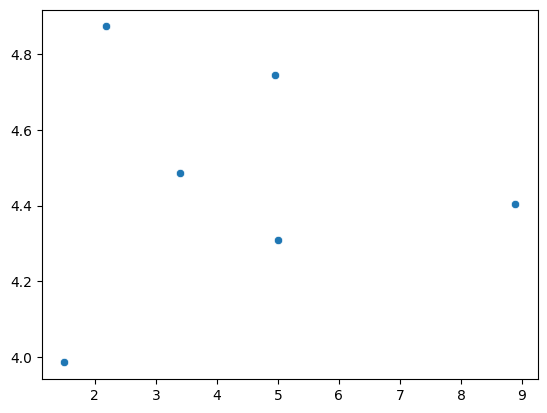

In [126]:
import seaborn as sns
target = y[:,14096]
indices_target = [i for i,x in enumerate(target) if x > 0]
feature_number = 2984
indices_feature = [i for i, x in enumerate(dense_array[:,feature_number]) if x > 0]
# Convert the lists to sets
set1 = set(indices_feature)
set2 = set(indices_target)

# Find the common indexes using the intersection operation
common_indexes = list(set1.intersection(set2))
sns.scatterplot(x = dense_array[common_indexes,feature_number], y = target[common_indexes])

# dense_array.shape[1]

In [128]:
# for tartet target = y[:,14096], lets choose only rows when its values are
# not zero and try to evaluate how many columns (feautres) have enought non null data
# to include in the model.
target = y[:,14096]
indices_target = [i for i,x in enumerate(target) if x != 0]
print(len(indices_target))
# subsetting dense_array to choose only rows that have non zero target
X_14096 = dense_array[indices_target,:]


966


In [138]:
X_14096.shape

(966, 228942)

In [139]:
start_time = time.time()
feat_not_null = [sum(X_14096[:,i] !=0) for i in range(X_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))

--- 18.943912267684937 seconds ---


In [140]:
start_time = time.time()
feat_not_null = [np.count_nonzero(X_14096[:,i]) for i in range(X_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))


--- 1.0528972148895264 seconds ---


Text(0.5, 1.0, 'Histogram of not null number of rows in a feature')

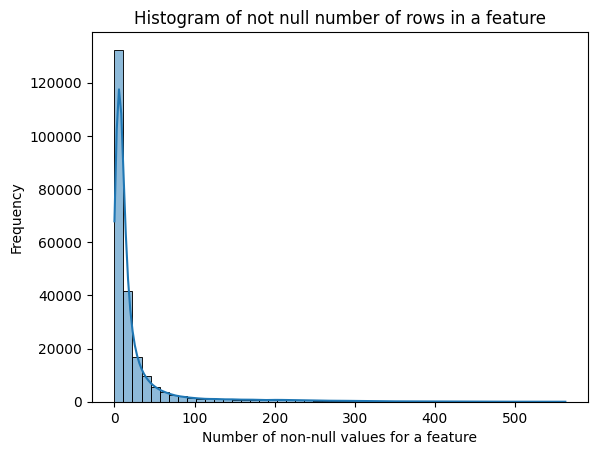

In [143]:
sns.histplot(feat_not_null, bins=50, kde=True)  # 'bins' controls the number of bins, 'kde' adds a kernel density estimation plot

# Add labels and a title
plt.xlabel("Number of non-null values for a feature")
plt.ylabel("Frequency")
plt.title("Histogram of not null number of rows in a feature")


In [154]:
top_10_values

array([563, 555, 547, 545, 541, 539, 538, 529, 521, 519])

In [158]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 10 indexes
top_10_values = np.array(feat_not_null)[sorted_indexes[:10]]
top_10_indexes = sorted_indexes[:10]
X_14096_train = X_14096[:,top_10_indexes]
y_1496_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_1496_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_1496_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.5829453175841457, pvalue=5.234661725078689e-89)
# --- 7.926203727722168 seconds ---
# Next step is to see if we get more accuracy with more features.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.182 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.216 total time=   0.1s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.200 total time=   0.1s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.255 total time=   0.1s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.206 total time=   0.1s
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.176 total time=   0.1s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.209 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.199 total time=   0.1s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.253 total time=   0.1s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.200 total time=   0.1s
[CV 1/5] END learni

In [ ]:
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 20 indexes
top_20_values = np.array(feat_not_null)[sorted_indexes[:20]]
top_20_indexes = sorted_indexes[:20]
X_14096_train = X_14096[:,top_20_indexes]
y_1496_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_1496_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_1496_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.681957300629006, pvalue=4.133401202661129e-133)
# --- 8.606647491455078 seconds ---
# We do getting more accuracy using more data. Let's see what happens if we use 30.

In [160]:
# Get the indexes that would sort the array in descending order
sorted_indexes = np.argsort(feat_not_null)[::-1]

# Get the values corresponding to the top 20 indexes
top_30_values = np.array(feat_not_null)[sorted_indexes[:30]]
top_30_indexes = sorted_indexes[:30]
X_14096_train = X_14096[:,top_30_indexes]
y_14096_train = y[indices_target,14096]

start_time = time.time()
# Create an instance of XGBRegressor
xgb_model = XGBRegressor(n_jobs=-1,tree_method="gpu_hist", sampling_method='gradient_based')
#X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.2, random_state=3)

# Define the parameter grid for GridSearchCV
param_grid = {
    #'n_estimators': [100, 200, 300],
    #'max_depth': [3, 5, 7, 9],
    'learning_rate': [0.1, 0.5],
    #'min_child_weight': [1, 3, 5],
    #'subsample': [0.7, 0.8, 0.9],
    #'colsample_bytree': [0.7, 0.8, 0.9],
    'reg_alpha': [1, 5, 100],
    'reg_lambda': [1, 5, 100]
}

# Create a GridSearchCV instance
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           cv=5, scoring='neg_mean_squared_error',verbose = 3)

# Fit the GridSearchCV instance on the data
grid_search.fit(X_14096_train, y_14096_train)

# Print the best parameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best model from the grid search
best_model = grid_search.best_estimator_

# Use the best model to make predictions on the train set
y_pred = best_model.predict(X_14096_train)

# Calculate the mean squared error on the train set
pe = scipy.stats.pearsonr(y_14096_train, y_pred)
print("Pearson Error on test set:", pe)
print("--- %s seconds ---" % (time.time() - start_time))

# Best parameters: {'learning_rate': 0.1, 'reg_alpha': 5, 'reg_lambda': 100}
# Pearson Error on test set: PearsonRResult(statistic=0.7347193028601066, pvalue=1.1964323780237837e-164)
# --- 9.407515525817871 seconds ---
# Not such big improvement as in previlous case, but still better. Let's analyse how much data have
# features that are in the first 30.

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.175 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.200 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.195 total time=   0.2s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.253 total time=   0.2s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=1;, score=-0.224 total time=   0.2s
[CV 1/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.177 total time=   0.2s
[CV 2/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.196 total time=   0.2s
[CV 3/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.192 total time=   0.2s
[CV 4/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.234 total time=   0.2s
[CV 5/5] END learning_rate=0.1, reg_alpha=1, reg_lambda=5;, score=-0.220 total time=   0.2s
[CV 1/5] END learni

In [163]:
# Get the values corresponding to the top 10 indexes
np.array(feat_not_null)[sorted_indexes[:50]]

array([563, 555, 547, 545, 541, 539, 538, 529, 521, 519, 517, 509, 509,
       508, 507, 507, 505, 505, 502, 501, 501, 500, 500, 497, 496, 495,
       494, 493, 493, 492, 492, 488, 487, 484, 481, 481, 481, 480, 477,
       475, 474, 474, 474, 472, 471, 470, 470, 468, 467, 465])

In [190]:
# Let's see how many non-null target values we have at all 
target = h5py.File(train_multi_targets,'r')#, mode)
target_train_14096 = target['train_multi_targets']['block0_values'][:,14096]
indices_target_14096 = [i for i,x in enumerate(target_train_14096) if x != 0]
target_14096 = target_train_14096[indices_target_14096]

In [193]:
Xm_train = h5py.File(train_multi_inputs,'r')
time_start = time.time()
train_14096 = Xm_train['train_multi_inputs']['block0_values'][indices_target_14096,:]
print("--- %s seconds ---" % (time.time() - start_time))
#--- 22983.674932718277 seconds ---

--- 22983.674932718277 seconds ---


In [172]:
np.count_nonzero(target_train_14096)
# So, we have 5130 cells in wich target for 14096 RNK fragmen has not null value.
# Our next task is to read rows with all the features for the same cells
# My main question is, can I use just the row number or should I use cell_id to get them?


In [181]:
Xm_train = h5py.File(train_multi_inputs,'r')
cell_id_train = Xm_train['train_multi_inputs']['axis1']
cell_id_target = target['train_multi_targets']['axis1']
print(cell_id_train[:5], cell_id_target[:5])
print(cell_id_train == cell_id_target)

[b'56390cf1b95e' b'fc0c60183c33' b'9b4a87e22ad0' b'81cccad8cd81'
 b'15cb3d85c232'] [b'56390cf1b95e' b'fc0c60183c33' b'9b4a87e22ad0' b'81cccad8cd81'
 b'15cb3d85c232']
False


In [184]:
#print(len(cell_id_train), len(cell_id_target))
for index, (elem1, elem2) in enumerate(zip(cell_id_train, cell_id_target)):
    if elem1 != elem2:
        print(f"The first differing element is at index {index}: {elem1} (cell_id_train) vs {elem2} (cell_id_target)")
        break
else:
    print("The lists are identical.")

The lists are identical.


In [185]:
t_cell_id_train = tuple(cell_id_train)
t_cell_id_target = tuple(cell_id_target)
t_cell_id_target == t_cell_id_train

True

So the lists of cell_id in train_multi_inputs and train_multi_targets are identical.
This means we can ignore cell_id and just use row number in the corresponding data tables.

In [ ]:
Xm_train = h5py.File(train_multi_inputs,'r')
time_start = time.time()
train_14096 = Xm_train['train_multi_inputs']['block0_values'][indices_target_14096,:]
print("--- %s seconds ---" % (time.time() - start_time))
#--- 22983.674932718277 seconds ---

In [ ]:
#Lets find 50 features with the most infomration and see if they are the same as in 20000 sample.
# Split on test and train
# Tune hyperparemeters in XGBRegressor
# Build model
# verify on test

In [194]:
start_time = time.time()
feat_not_null_14096 = [np.count_nonzero(train_14096[:,i]) for i in range(train_14096.shape[1] )]
print("--- %s seconds ---" % (time.time() - start_time))


--- 11.617905139923096 seconds ---


In [5]:
loaded_svd_pipeline = joblib.load('svd_model_10500_6000.joblib')
X = loaded_svd_pipeline.transform(sampled_sparse_matrix1)
target = h5py.File(train_multi_targets,'r')#, mode)
y = target['train_multi_targets']['block0_values'][first_sample_indices,:]

For indices in our random samples of observations we need to get corresponding cell_ids

In [12]:
sample_cell_id

array([b'a7791bcf1152', b'00f283126092', b'e31ca103a4ac', ...,
       b'd702b0ffa5f4', b'69451694ec4c', b'553bca99ba78'], dtype='|S12')

In [49]:
ids = [i.decode('UTF-8') for i in sample_cell_id]

Using cell id get day and donor_id from metadata

In [54]:
metadata_df = pd.read_csv(metadata)
mult = metadata_df[metadata_df['technology'] == 'multiome'].drop('technology', axis=1)

In [55]:
# To make the result in the same order as in sample_cell_id
# Convert 'cell_id' to categorical with custom order
mult['cell_id'] = pd.Categorical(mult['cell_id'], categories=ids, ordered=True)
# Filtering using isin()
mult_f = mult[mult['cell_id'].isin(ids)]

In [56]:
mult_f.drop(['cell_type','donor'],axis=1, inplace=True)

/tmp/ipykernel_9093/1095377528.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mult_f.drop(['cell_type','donor'],axis=1, inplace=True)


In [57]:
mult_f.head()

,cell_id,day
152608,a7791bcf1152,2
152612,00f283126092,2
152616,e31ca103a4ac,2
152618,c9d7ec67e230,2
152620,89c1d660a925,2


In [58]:
encoded_mult_f = pd.get_dummies(mult_f, columns=['day'], prefix=['day'])

In [59]:
encoded_mult_f.head()

,cell_id,day_2,day_3,day_4,day_7
152608,a7791bcf1152,True,False,False,False
152612,00f283126092,True,False,False,False
152616,e31ca103a4ac,True,False,False,False
152618,c9d7ec67e230,True,False,False,False
152620,89c1d660a925,True,False,False,False


Concatenate to the right day and donor_id to the svd transformed data.

Run model to check on the effect.

In [3]:
train_cite_inputs = os.path.join(data_path,"train_cite_inputs.h5")
train_cite_targets = os.path.join(data_path,"train_cite_targets.h5")
test_cite_inputs = os.path.join(data_path,"test_cite_inputs.h5")

train_multi_inputs = os.path.join(data_path,"train_multi_inputs.h5")
train_multi_targets = os.path.join(data_path,"train_multi_targets.h5")
test_multi_inputs = os.path.join(data_path,"test_multi_inputs.h5")
text = f"'{train_cite_inputs}'"
print(text)

'/home/skovtun/Single cell/Single_cell_data/train_cite_inputs.h5'
